# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
import string
from collections import Counter
import datetime as dt
import pickle as pkl
import os
import json
import matplotlib.pyplot as plt
import re
#import jsonlines
import numpy as np
from collections import defaultdict
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
    from google.colab import drive
    drive.mount('/content/gdrive')
    path = 'gdrive/My Drive/'
else:
    current_device = 'cpu'
    path = './'


## I. N-Gram Language Modeling

#### Utilities

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [3]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [0]:
wiki_datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(wiki_datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, wiki_datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, wiki_datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [4]:
class NGramInterpolation(object):
    def __init__(self, n, lambdas, vsize, total_word_count):
        self.n = n
        self.lambdas = lambdas
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
        self.total_word_count = total_word_count
        
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(self.n-1, len(padded_sequence)):
                ngram = tuple(padded_sequence[i-self.n+1:i+1])
                for j in range(1, self.n):
                    prefix, word = ngram[:j], ngram[j]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1 
                    self.total[word] += 1
                    
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prob = self.lambdas[-1]/self.vsize
        word = ngram[-1]
        prob += (self.total[word] / self.total_word_count) * self.lambdas[-2]
        for nk in range(len(ngram) - 1):
            prefix = ngram[nk:-1]
            if self.total[prefix] > 1e-9:
                prob += ((self.count[prefix][word])/ (self.total[prefix])) * self.lambdas[nk]
            
        return prob

In [0]:
total_wc = len([t for ts in wiki_datasets['train'] for t in ts])
print(total_wc)

1924754


#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [0]:
found = False
while not(found):
    perplexs = []
    for n in [2, 3, 4]:
        #lambdas = [1/(n+1) for i in range(n+1)]

        # Uncomment to input in the following format #.##,#.##,#.##(...)
        # lam = input()
        # lambdas = [float(i) for i in lam.split(",")]

        # Random search using Dirichlet Distribution (Notice: lambdas add to 1)
        lambdas = np.ravel(np.random.dirichlet(np.ones(n),size=1))
        print('Lambdas add to:',sum(np.ravel(np.random.dirichlet(np.ones(n),size=1))))

        lm = NGramInterpolation(n=n, lambdas=lambdas, vsize=len(vocab)+1, total_word_count = total_wc)  # +1 is for <eos>
        lm.estimate(wiki_datasets['train'])

        print("lambdas = " + str(lambdas))
        print("Interpolation, n=%d | Train Perplexity: %.3f" % (n, perplexity(lm, wiki_datasets['train'])))
        print("Interpolation, n=%d | Valid Perplexity: %.3f" % (n, perplexity(lm, wiki_datasets['valid'])))
        perplexs.append(perplexity(lm, wiki_datasets['valid']))
        
        # If initial perplexity is not better than Additive Smoothing
        if (n == 2) and perplexs[n-2] > 525:
            break
        
        # If the next n-gram is not better than last one found
        if ( n > 2 ):
            if (perplexs[n-2] < perplexs[n-3]):
                if n == 4:
                    found = True
                    print("A good configuration has been found")
                continue
            else:
                break

Lambdas add to: 1.0
lambdas = [0.20953827 0.79046173]
Interpolation, n=2 | Train Perplexity: 262.011
Interpolation, n=2 | Valid Perplexity: 516.755
Lambdas add to: 0.9999999999999999
lambdas = [0.25564492 0.49439094 0.24996414]
Interpolation, n=3 | Train Perplexity: 18.841
Interpolation, n=3 | Valid Perplexity: 170.144
Lambdas add to: 1.0
lambdas = [0.13951532 0.01370735 0.57312293 0.27365439]
Interpolation, n=4 | Train Perplexity: 10.124
Interpolation, n=4 | Valid Perplexity: 158.523
A good configuration has been found


## II. Neural Language Modeling with a Recurrent Neural Network

## LSTM RNN Model 

In [5]:
print('Current device: {}'.format(current_device))
print('Current path: {}'.format(path))

Current device: cpu
Current path: ./


In [6]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def tokenize(document):
    tokens = tokenizer(document)
    tokens = [token.text.lower() for token in tokens if (token.text not in punctuations)]
    return tokens

In [7]:
def load_wikitext(fname):
    full_lines = []
    datasets_text = {
        'train': [],
        'valid': [],
        'test': [],
    }
    for jline in jsonlines.open(fname):
        for split in datasets_text.keys():
            for sentence in tqdm(jline[split]):
                datasets_text[split].append(tokenize(sentence))
        
    return datasets_text

In [0]:
# wikitext = load_wikitext('/Users/Antonio/Downloads/wikitext2-sentencized.json')

In [0]:
# pkl.dump(wikitext['train'], open('wiki_train_tokenized.p','wb'))
# pkl.dump(wikitext['valid'], open('wiki_val_tokenized.p', 'wb'))
# pkl.dump(wikitext['test'], open('wiki_test_tokenized.p','wb'))
# pkl.dump(wikitext, open('wiki_all_tokenized.p','wb'))

In [8]:
def load_wiki_data(path):
    wiki_train = pkl.load(open(path+'wiki_train_tokenized.p','rb'))
    wiki_val = pkl.load(open(path+'wiki_val_tokenized.p','rb'))
    wiki_test = pkl.load(open(path+'wiki_test_tokenized.p','rb'))
    wiki_all = pkl.load(open(path+'wiki_all_tokenized.p','rb'))
    
    return wiki_train, wiki_val, wiki_test, wiki_all

In [9]:
wiki_train, wiki_val, wiki_test, wiki_all = load_wiki_data(path)

In [10]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')

        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
# wiki_dict = Dictionary(wiki_all, include_valid = False)

100%|██████████| 78274/78274 [01:37<00:00, 800.05it/s] 


In [0]:
# pkl.dump(wiki_dict, open('wiki_dictionary.p','wb'))

# Included pickled `wiki_dict` to avoid creating object
takes around 1.5 mins to create..

In [11]:
wiki_dict = pkl.load(open(path+'wiki_dictionary.p','rb'))

In [12]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [13]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [14]:
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [15]:
def build_ngram_loader(dataset, dataset_dict, ngram_order, batch_size=2048):
    tokenized_ngram_dataset = tokenize_dataset(dataset, dataset_dict, ngram_order)
    #sliced_ngram = slice_sequences_given_order(tokenized_ngram_dataset, ngram_order)

    ngram_datasets = {}
    ngram_loaders = {}
    for split, tokenized_dataset in tokenized_ngram_dataset.items():
        ngram_datasets[split] = TensoredDataset(tokenized_dataset)
    
    for split, tensored_dataset in ngram_datasets.items():
        ngram_loaders[split] = DataLoader(tensored_dataset, batch_size=batch_size, shuffle=True,\
                                          collate_fn=pad_collate_fn)
    return ngram_datasets, ngram_loaders

In [16]:
wiki_datasets, wiki_loaders = build_ngram_loader(wiki_all, wiki_dict, 4, 128)

100%|██████████| 9708/9708 [00:00<00:00, 148654.69it/s]


## LSTM

In [17]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [0]:
# check out eventually; below values are from lab 4
# embedding_size = 256
# hidden_size = 512
# num_layers = 3
# rnn_dropout = 0.3

In [18]:
### values included here are BASELINE only
hidden_size = 128
embedding_size = 64
rnn_dropout = 0.1
num_layers = 2

options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

In [19]:
lstm_model = LSTMModel(options).to(current_device)

In [20]:
learn_rate = 0.001
lstm_criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

# lstm_model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learn_rate)

In [21]:
def lstm_perplexity(ce_loss):
  return (2**(ce_loss/np.log(2)))
  

In [22]:
import datetime as dt
def train_lstm(model, loaders_dict, criterion, optimizer, path_to_save = path+'baseline_lstm.pt'):
    start_time = dt.datetime.now()
    print('{} | Starting training'.format(start_time))
    
    
    plot_cache = []
    best_perplexity = float('Inf')
    
    for epoch_number in range(10):
        print('{} | Epoch {}'.format(dt.datetime.now(), epoch_number+1))
        
        avg_loss = -1.0
        model.train()
        train_log_cache = []
        
            #for i, (inp, target) in enumerate(persona_ngram_loaders['train']):
        for i, (inp, target) in enumerate(loaders_dict['train']):
            
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())  
        
            if i % 100 == 0: 
              print('{} | Number steps {}'.format(dt.datetime.now(), i))
                
        avg_loss = sum(train_log_cache)/len(train_log_cache)
        print('{} | Epoch {} avg train loss = {:.{prec}f}'.format(dt.datetime.now(), epoch_number+1, avg_loss, prec=4))
     
        train_log_cache = []
      
        #do valid
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders_dict['valid']):

                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Epoch {} validation loss = {:.{prec}f}'.format(epoch_number+1, avg_val_loss, prec=4))

            plot_cache.append((avg_loss, avg_val_loss))
            val_ppl = lstm_perplexity(avg_val_loss)
            print('Epoch {}, perplexity achieved {}'.format(epoch_number+1, val_ppl))
            if val_ppl < best_perplexity:
              torch.save(model.state_dict(), path_to_save)
              best_perplexity = val_ppl
    print('{} | Finished training in {}'.format(dt.datetime.now(), dt.datetime.now() - start_time))
          
    return plot_cache

In [0]:
lstm_losses = train_lstm(lstm_model, wiki_loaders, lstm_criterion, lstm_optimizer)


In [0]:
for i, j in enumerate(lstm_losses):
    print('Epoch {}, perplexity {} '.format(i+1,lstm_perplexity(j[1])))

Epoch 1, perplexity 485.74431725177425 
Epoch 2, perplexity 340.5988893900643 
Epoch 3, perplexity 282.0407894433271 
Epoch 4, perplexity 248.94715152003695 
Epoch 5, perplexity 227.81834640900593 
Epoch 6, perplexity 211.63231959516264 
Epoch 7, perplexity 202.8889041485416 
Epoch 8, perplexity 195.41396969511615 
Epoch 9, perplexity 189.1255822014498 
Epoch 10, perplexity 185.00784711463538 


In [0]:
pkl.dump(lstm_losses, open('baseline_lstm_losses.p','wb'))

## RNN

In [23]:
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [24]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
    path = 'gdrive/My Drive/'
else:
    current_device = 'cpu'
    path = './'

rnn_model = RNNModel(options).to(current_device)

In [25]:
learn_rate = 0.001
rnn_criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

# lstm_model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learn_rate)

In [26]:
import datetime as dt
def train_rnn(model, loaders_dict, criterion, optimizer, path_to_save = path+'baseline_rnn.pt'):
    start_time = dt.datetime.now()
    print('{} | Starting training'.format(start_time))
    
    
    plot_cache = []
    best_perplexity = float('Inf')
    
    for epoch_number in range(10):
        print('{} | Epoch {}'.format(dt.datetime.now(), epoch_number+1))
        
        avg_loss = -1.0
        model.train()
        train_log_cache = []
        
            #for i, (inp, target) in enumerate(persona_ngram_loaders['train']):
        for i, (inp, target) in enumerate(loaders_dict['train']):
            
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())  
        
            if i % 100 == 0: 
              print('{} | Number steps {}'.format(dt.datetime.now(), i))
                
        avg_loss = sum(train_log_cache)/len(train_log_cache)
        print('{} | Epoch {} avg train loss = {:.{prec}f}'.format(dt.datetime.now(), epoch_number+1, avg_loss, prec=4))
     
        train_log_cache = []
      
        #do valid
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders_dict['valid']):

                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Epoch {} validation loss = {:.{prec}f}'.format(epoch_number+1, avg_val_loss, prec=4))

            plot_cache.append((avg_loss, avg_val_loss))
            
            # Perplexity function is the same LSTM/RNN
            val_ppl = lstm_perplexity(avg_val_loss)
            print('Epoch {}, perplexity achieved {}'.format(epoch_number+1, val_ppl))
            if val_ppl < best_perplexity:
              torch.save(model.state_dict(), path_to_save)
              best_perplexity = val_ppl
    print('{} | Finished training in {}'.format(dt.datetime.now(), dt.datetime.now() - start_time))
          
    return plot_cache

In [0]:
rnn_losses = train_rnn(rnn_model, wiki_loaders, rnn_criterion, rnn_optimizer)
pkl.dump(rnn_losses, open('baseline_rnn_losses.p','wb'))

2019-10-02 01:00:27.574590 | Starting training
2019-10-02 01:00:27.576968 | Epoch 1
2019-10-02 01:00:27.878605 | Number steps 0
2019-10-02 01:00:47.922668 | Number steps 100
2019-10-02 01:01:08.081708 | Number steps 200
2019-10-02 01:01:28.989724 | Number steps 300
2019-10-02 01:01:48.858173 | Number steps 400
2019-10-02 01:02:08.982005 | Number steps 500
2019-10-02 01:02:29.433522 | Number steps 600
2019-10-02 01:02:31.459611 | Epoch 1 avg train loss = 6.4174
Epoch 1 validation loss = 5.7755
Epoch 1, perplexity achieved 322.2948576543607
2019-10-02 01:02:37.076556 | Epoch 2
2019-10-02 01:02:37.323707 | Number steps 0
2019-10-02 01:02:57.181535 | Number steps 100
2019-10-02 01:03:17.869424 | Number steps 200
2019-10-02 01:03:38.507705 | Number steps 300
2019-10-02 01:03:58.383793 | Number steps 400
2019-10-02 01:04:18.900043 | Number steps 500
2019-10-02 01:04:39.431193 | Number steps 600
2019-10-02 01:04:41.610963 | Epoch 2 avg train loss = 5.8439
Epoch 2 validation loss = 5.5393
Epoc

RuntimeError: ignored

In [0]:
# !kill -9 -1

### II.1 LSTM and Hyper-Parameters

In [27]:
def grid_search(emb_dims, dropouts):
    
    
    
    for emb_dim in emb_dims:
        for dropout in dropouts:
      
            options = {
                'num_embeddings': len(wiki_dict),
                'embedding_dim': emb_dim,
                'padding_idx': wiki_dict.get_id('<pad>'),
                'input_size': emb_dim,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'rnn_dropout': dropout,
            }
            lstm_model = LSTMModel(options).to(current_device)
            lstm_losses = train_lstm(lstm_model, wiki_loaders, lstm_criterion, lstm_optimizer, path+ "emb_dim=" + str(emb_dim) + "_dropout=" + str(dropout) + ".pt")
            pkl.dump(lstm_losses, open(path+ "emb_dim=" + str(emb_dim) +  "_dropout=" + str(dropout) + ".p",'wb'))

#### Results (LSTM vs. Baseline)

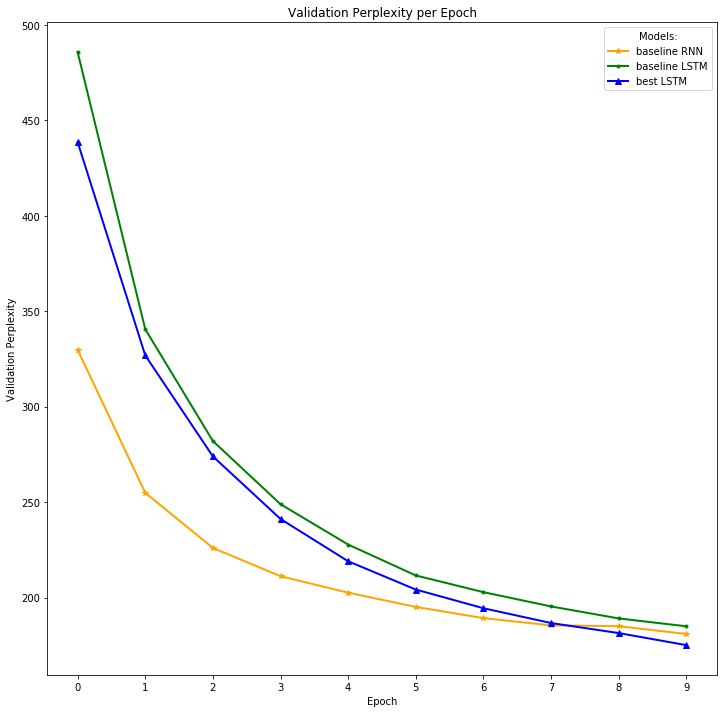

In [28]:
rnn_baseline_ppl = pkl.load(open(path+ 'baseline_rnn_losses.p','rb'))
rnn_baseline_ppl = [lstm_perplexity(ppl[1]) for ppl in rnn_baseline_ppl]

lstm_baseline_ppl = pkl.load(open(path+ 'baseline_lstm_losses.p','rb'))
lstm_baseline_ppl = [lstm_perplexity(ppl[1]) for ppl in lstm_baseline_ppl]

best_lstm_ppl = pkl.load(open(path+ 'Grid Search/emb_dim=128_dropout=0.1.p','rb'))
best_lstm_ppl = [lstm_perplexity(ppl[1]) for ppl in best_lstm_ppl]

plt.figure(figsize=(12,12))
plt.plot([i for i in range(len(rnn_baseline_ppl))], rnn_baseline_ppl, marker='*', color='orange', linewidth=2, label = 'baseline RNN')
plt.plot([i for i in range(len(lstm_baseline_ppl))], lstm_baseline_ppl, marker='.',color='green', linewidth=2, label = 'baseline LSTM')
plt.plot([i for i in range(len(best_lstm_ppl))], best_lstm_ppl, marker='^',color='blue', linewidth=2, label = 'best LSTM')
plt.xticks([i for i in range(10)])
plt.title('Validation Perplexity per Epoch')
plt.ylabel('Validation Perplexity')
plt.xlabel('Epoch')
plt.legend(title='Models:')
plt.show()

As we can see from the graph the baseline LSTM model did not perfom better than the baseline RNN but the **best LSTM** (tuned) model (embedding_dimension = 128, dropout = 0.1) did outperfom the baseline RNN after training 10 epochs.

#### Performance Variation Based on Hyperparameter Values

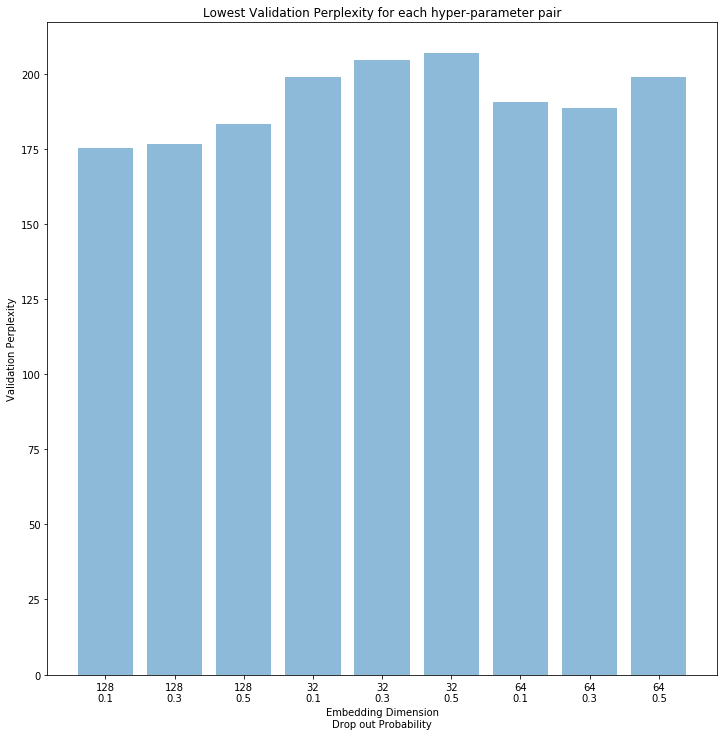

In [29]:
models_dir = [file for file in os.listdir(path+'Grid Search/') if file.endswith('.p')]
models_dir.sort()
perplexities = []
names = []
%matplotlib inline
for file in models_dir:
    ppl_file = pkl.load(open(path+'Grid Search/'+file,'rb'))
    perplexities.append(lstm_perplexity(ppl_file[-1][1]))
    emb_d = re.search(r'(?<=\=)\d+', file).group(0)
    drop_out = re.search(r'(?<=\=)\d\.\d', file).group(0)
    names.append(emb_d + '\n'+ drop_out)

x_pos = range(len(perplexities))
plt.figure(figsize=(12,12))
plt.bar(x_pos, perplexities, align='center', alpha=0.5)
plt.xticks(x_pos, names)
plt.ylabel('Validation Perplexity')
plt.xlabel('Embedding Dimension\nDrop out Probability')
plt.title('Lowest Validation Perplexity for each hyper-parameter pair')
plt.show()

The bar plot above shows the performance in terms of perplexity of every hyperparameter combination we tried.

Embedding_dimensions = {32, 64, 128}

Dropout = {0.1, 0.3, 0.5}

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [31]:
# !pip install umap-learn

In [32]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


#### Import best LSTM model with correct settings

In [33]:
lstm_best_hidden_size = 128
lstm_best_embedding_size = 128
lstm_best_rnn_dropout = 0.1
lstm_best_num_layers = 2

lstm_best_options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': lstm_best_embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': lstm_best_embedding_size,
        'hidden_size': lstm_best_hidden_size,
        'num_layers': lstm_best_num_layers,
        'rnn_dropout': lstm_best_rnn_dropout,
    }

In [34]:
lstm_best_model = LSTMModel(lstm_best_options).to("cpu")
lstm_best_model.load_state_dict(torch.load(path+'Grid Search/emb_dim=128_dropout=0.1.pt',map_location="cpu"))
lstm_best_model.eval()
print(lstm_best_model)

LSTMModel(
  (lookup): Embedding(28792, 128, padding_idx=2)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=28792, bias=True)
)


In [35]:
import torch.nn.functional as F

def find_similar_word(input_word,wiki_dict,model,linear_layer=False,verbose=False):
    emb_matrix = model.lookup.weight
    vocab_size = emb_matrix.size()[0]
    
    input_index = wiki_dict.get_id(input_word)
    input_tensor = emb_matrix[input_index]
    if linear_layer:
        input_tensor = model.projection(input_tensor)
    
    # ten best & worst
    ten_best = [(-1,None) for _ in range(10)]
    ten_worst = [(1,None) for _ in range(10)]
    
    for iter_index in range(0,vocab_size):
        if iter_index==input_index:
            continue
        candidate_tensor = emb_matrix[iter_index]
        if linear_layer:
            candidate_tensor = model.projection(candidate_tensor)
        sim = F.cosine_similarity(input_tensor,candidate_tensor,dim=0)
        
        # sort into best
        ten_best.append((sim,iter_index))
        ten_best.sort()
        ten_best.reverse()
        ten_best = ten_best[:10]
        
        # sort into worst
        ten_worst.append((sim,iter_index))
        ten_worst.sort()
        ten_worst = ten_worst[:10]
    
    distances = []
    closest_ids = []
    closest_words = []
    if verbose:
        print("~Printing closest words for:",input_word)
    for (dist,idx) in ten_best:
        distance = dist.detach().numpy()
        distances.append(distance)
        closest_ids.append(idx)
        word = wiki_dict.get_token(idx)
        closest_words.append(word)
        if verbose:
            print("Word:",word)
            print("Distance:",distance)
        
    distances = []
    farthest_ids = []
    farthest_words = []
    if verbose:
        print("\n~Printing furthest words for:",input_word)
    for (dist,idx) in ten_worst:
        distance = dist.detach().numpy()
        distances.append(distance)
        farthest_ids.append(idx)
        word = wiki_dict.get_token(idx)
        farthest_words.append(word)
        if verbose:
            print("Word:",word)
            print("Distance:",distance)
        
    return closest_ids, closest_words, farthest_ids, farthest_words

In [36]:
def find_and_plot_similar(word,wiki_dict,model,linear_layer=False,verbose=False):
    closest_ids, closest_words, farthest_ids, farthest_words = find_similar_word(word,wiki_dict,model,linear_layer,verbose)
    word_id = wiki_dict.get_id(word)
    all_words = [word] + closest_words + farthest_words
    all_ids = [word_id] + closest_ids + farthest_ids
    
    if verbose:
        print("\n")
        print(all_words)
        print(all_ids)
        
    embedding_matrix = lstm_best_model.lookup.weight
    umap_plot(embedding_matrix, all_ids, all_words)

#### II.2.1 Word Similarity

#### II.2.2 Embedding Layer

~Printing closest words for: run
Word: alluded
Distance: 0.3553196
Word: prompts
Distance: 0.3448161
Word: cautiously
Distance: 0.33822453
Word: councils
Distance: 0.3201861
Word: ordinated
Distance: 0.31427938
Word: optimal
Distance: 0.30636662
Word: campaigned
Distance: 0.29571116
Word: guide
Distance: 0.2953896
Word: groups
Distance: 0.29494783
Word: miracles
Distance: 0.29029915

~Printing furthest words for: run
Word: apprehends
Distance: -0.3571485
Word: holds
Distance: -0.33304116
Word: intimacy
Distance: -0.3142384
Word: ides
Distance: -0.31286946
Word: alun
Distance: -0.3122073
Word: trying
Distance: -0.31213424
Word: onomatopoeia
Distance: -0.31151012
Word: cache
Distance: -0.3090949
Word: 119
Distance: -0.30104405
Word: churchmen
Distance: -0.30009112


['run', 'alluded', 'prompts', 'cautiously', 'councils', 'ordinated', 'optimal', 'campaigned', 'guide', 'groups', 'miracles', 'apprehends', 'holds', 'intimacy', 'ides', 'alun', 'trying', 'onomatopoeia', 'cache', '119', 'church

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


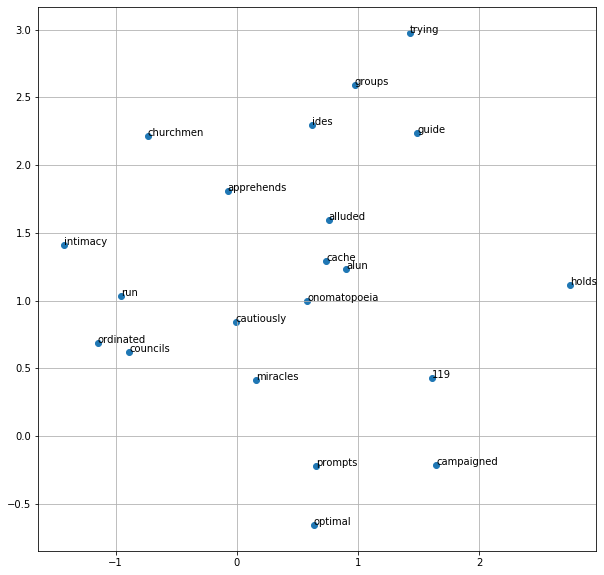

~Printing closest words for: book
Word: 245
Distance: 0.33284697
Word: farsley
Distance: 0.31698772
Word: fatima
Distance: 0.311865
Word: semantic
Distance: 0.3115352
Word: mandy
Distance: 0.30227664
Word: acclaim
Distance: 0.30156094
Word: poehler
Distance: 0.30013317
Word: wieselman
Distance: 0.2935726
Word: 2d
Distance: 0.29080433
Word: shriners
Distance: 0.28880095

~Printing furthest words for: book
Word: gar
Distance: -0.32868758
Word: midpoint
Distance: -0.31578907
Word: 1872
Distance: -0.30505797
Word: libanius
Distance: -0.3016268
Word: klaus
Distance: -0.29987505
Word: distinguish
Distance: -0.29909062
Word: dormitories
Distance: -0.2984799
Word: mercenary
Distance: -0.29487216
Word: lumbering
Distance: -0.29190925
Word: automated
Distance: -0.28966695


['book', '245', 'farsley', 'fatima', 'semantic', 'mandy', 'acclaim', 'poehler', 'wieselman', '2d', 'shriners', 'gar', 'midpoint', '1872', 'libanius', 'klaus', 'distinguish', 'dormitories', 'mercenary', 'lumbering', 'automated

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


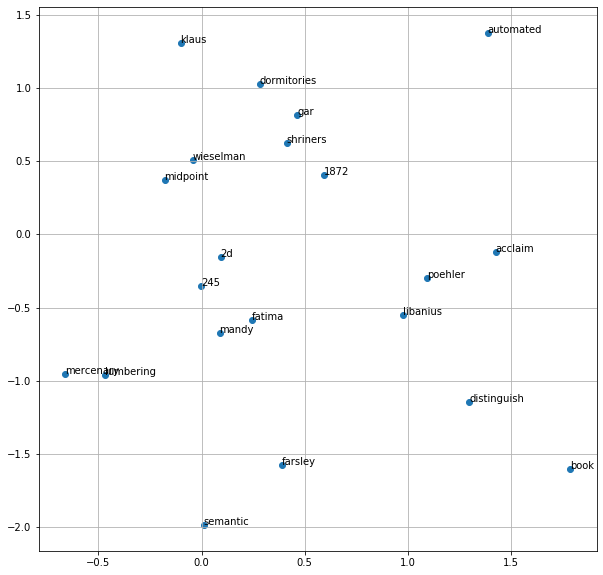

~Printing closest words for: church
Word: communication
Distance: 0.33648863
Word: 650
Distance: 0.313554
Word: freya
Distance: 0.30611455
Word: aspect
Distance: 0.30380893
Word: ramsay
Distance: 0.30105376
Word: timpani
Distance: 0.3008925
Word: bree
Distance: 0.2931851
Word: portico
Distance: 0.29178268
Word: 1868
Distance: 0.28944656
Word: thorns
Distance: 0.28909272

~Printing furthest words for: church
Word: rescind
Distance: -0.34512445
Word: t.s.
Distance: -0.34496692
Word: kashgar
Distance: -0.34342402
Word: e3
Distance: -0.32222718
Word: americanus
Distance: -0.29986534
Word: coincidences
Distance: -0.299426
Word: motoko
Distance: -0.29930013
Word: guillaume
Distance: -0.29835534
Word: shouts
Distance: -0.29433286
Word: mild
Distance: -0.29403612


['church', 'communication', '650', 'freya', 'aspect', 'ramsay', 'timpani', 'bree', 'portico', '1868', 'thorns', 'rescind', 't.s.', 'kashgar', 'e3', 'americanus', 'coincidences', 'motoko', 'guillaume', 'shouts', 'mild']
[1732, 3695, 

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


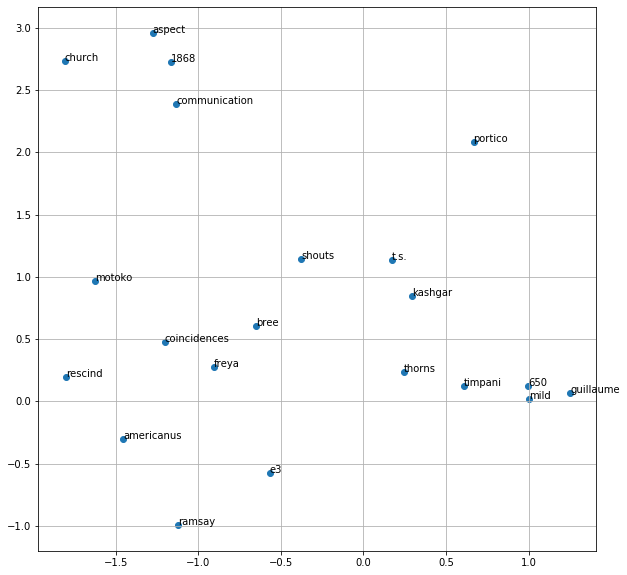

~Printing closest words for: sex
Word: unicameral
Distance: 0.35018486
Word: 835
Distance: 0.33817306
Word: cascade
Distance: 0.33070326
Word: culver
Distance: 0.32808042
Word: oregon
Distance: 0.31686434
Word: prospered
Distance: 0.31251088
Word: goo
Distance: 0.31180486
Word: ensuing
Distance: 0.30561697
Word: diversionary
Distance: 0.29882315
Word: day
Distance: 0.29392537

~Printing furthest words for: sex
Word: hutchings
Distance: -0.37683666
Word: affiliate
Distance: -0.36746424
Word: 511
Distance: -0.31914872
Word: executioner
Distance: -0.30481964
Word: advisers
Distance: -0.30414656
Word: rhodesian
Distance: -0.303659
Word: stairway
Distance: -0.3026471
Word: guildhall
Distance: -0.2971823
Word: eddie
Distance: -0.29717314
Word: mortis
Distance: -0.29023227


['sex', 'unicameral', '835', 'cascade', 'culver', 'oregon', 'prospered', 'goo', 'ensuing', 'diversionary', 'day', 'hutchings', 'affiliate', '511', 'executioner', 'advisers', 'rhodesian', 'stairway', 'guildhall', 'eddie', 

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


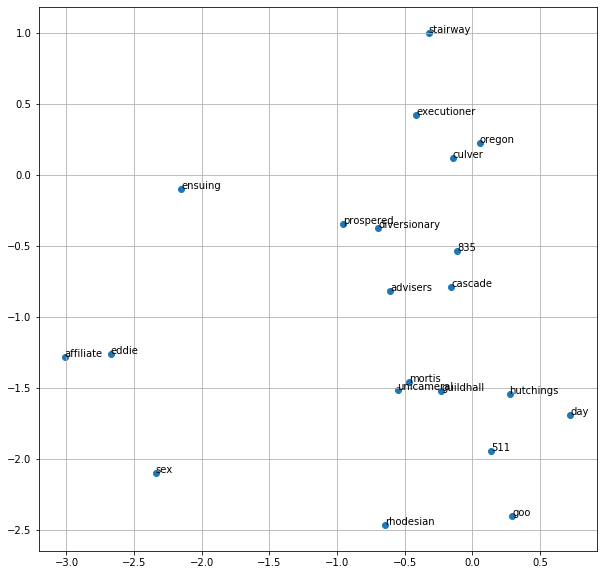

~Printing closest words for: sunny
Word: sihanoukville
Distance: 0.35348338
Word: aforesaid
Distance: 0.3334106
Word: withoos
Distance: 0.32882544
Word: affectionate
Distance: 0.31363574
Word: dismayed
Distance: 0.30282795
Word: mick
Distance: 0.30039725
Word: divided
Distance: 0.29843274
Word: uncertain
Distance: 0.29782757
Word: wanna
Distance: 0.29671177
Word: merge
Distance: 0.2958587

~Printing furthest words for: sunny
Word: raasay
Distance: -0.32732373
Word: prolog
Distance: -0.3254991
Word: quartet
Distance: -0.319122
Word: rebellious
Distance: -0.31023437
Word: corrected
Distance: -0.3094371
Word: 591
Distance: -0.30762327
Word: jessica
Distance: -0.30680868
Word: campus
Distance: -0.30668715
Word: souper
Distance: -0.30363283
Word: carapace
Distance: -0.30074158


['sunny', 'sihanoukville', 'aforesaid', 'withoos', 'affectionate', 'dismayed', 'mick', 'divided', 'uncertain', 'wanna', 'merge', 'raasay', 'prolog', 'quartet', 'rebellious', 'corrected', '591', 'jessica', 'campus', 

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


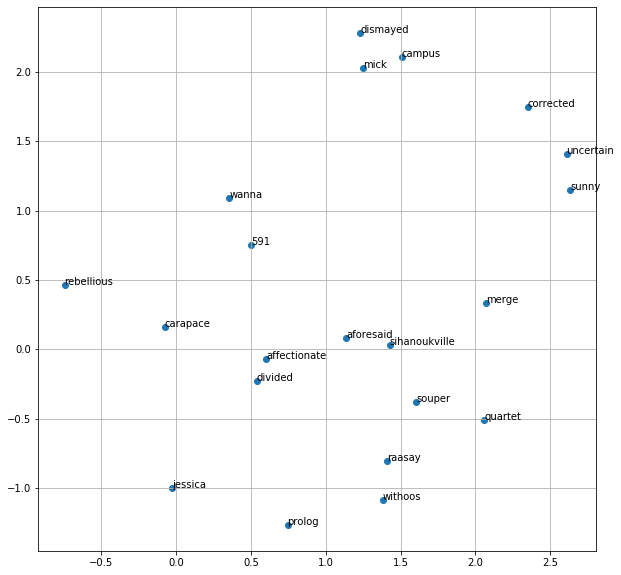

In [38]:
words = ["run", "book", "church", "sex", "sunny"]
for word in words:
    find_and_plot_similar(word, wiki_dict, lstm_best_model, linear_layer=False, verbose=True)

#### II.2.3 Projection Layer

As we can see by comparing the results obtained above (Embedding Layer) and below (Linear Layer), the later achieves higher similarity scores. The visualization do differ, however, there does not seem to be clear/interpretable patterns in the obtained plots. Even in the areas where there seem to be clusters, the words are not deeply related in meaning.

~Printing closest words for: run
Word: godfrey
Distance: 0.7757449
Word: 450
Distance: 0.77397335
Word: bestseller
Distance: 0.76751417
Word: transcribes
Distance: 0.7594355
Word: hydraulic
Distance: 0.7500557
Word: prophecy
Distance: 0.74781233
Word: antelope
Distance: 0.73709035
Word: demarcation
Distance: 0.735106
Word: platoon
Distance: 0.7304617
Word: trim
Distance: 0.7293435

~Printing furthest words for: run
Word: polly
Distance: -0.7688583
Word: rediff.com
Distance: -0.7636427
Word: aggravated
Distance: -0.75220305
Word: battery
Distance: -0.75118774
Word: turk
Distance: -0.74585456
Word: kicks
Distance: -0.74046767
Word: crowns
Distance: -0.73710394
Word: hirosaki
Distance: -0.73291343
Word: invoked
Distance: -0.73239696
Word: courier
Distance: -0.7310158


['run', 'godfrey', '450', 'bestseller', 'transcribes', 'hydraulic', 'prophecy', 'antelope', 'demarcation', 'platoon', 'trim', 'polly', 'rediff.com', 'aggravated', 'battery', 'turk', 'kicks', 'crowns', 'hirosaki', 'invoked',

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


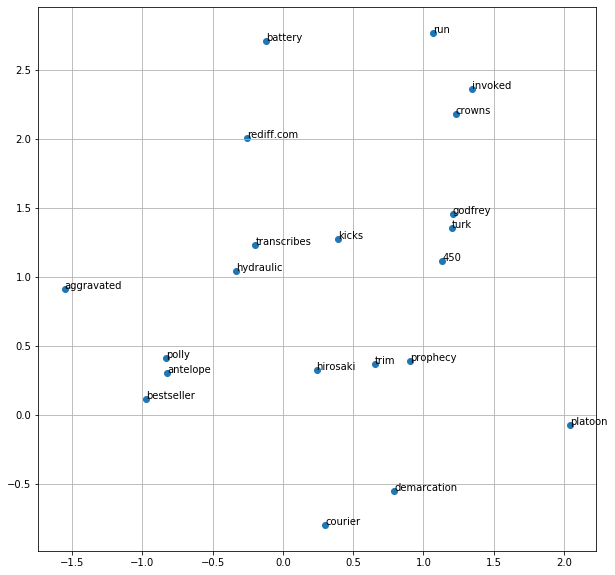

~Printing closest words for: book
Word: decorative
Distance: 0.46225014
Word: anger
Distance: 0.44444782
Word: tularemia
Distance: 0.43530637
Word: kneeling
Distance: 0.4333633
Word: innovator
Distance: 0.4215134
Word: guitarist
Distance: 0.42134628
Word: intertropical
Distance: 0.41406465
Word: cosmetics
Distance: 0.41286644
Word: flank
Distance: 0.4100551
Word: lane
Distance: 0.40706092

~Printing furthest words for: book
Word: colours
Distance: -0.48256627
Word: 618
Distance: -0.47107485
Word: trainer
Distance: -0.4641575
Word: rumor
Distance: -0.45749736
Word: buoy
Distance: -0.4505871
Word: truths
Distance: -0.44226846
Word: darryl
Distance: -0.44222566
Word: nielly
Distance: -0.437913
Word: carre
Distance: -0.43618068
Word: soldier
Distance: -0.43211278


['book', 'decorative', 'anger', 'tularemia', 'kneeling', 'innovator', 'guitarist', 'intertropical', 'cosmetics', 'flank', 'lane', 'colours', '618', 'trainer', 'rumor', 'buoy', 'truths', 'darryl', 'nielly', 'carre', 'soldier']
[1

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


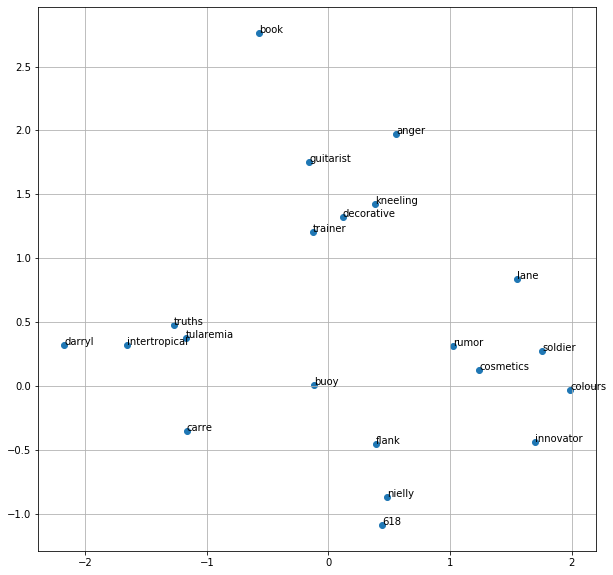

~Printing closest words for: church
Word: ardhanarishvara
Distance: 0.60929346
Word: taste
Distance: 0.60737294
Word: domain
Distance: 0.6069073
Word: combat
Distance: 0.600917
Word: sify
Distance: 0.6007058
Word: alternately
Distance: 0.59844184
Word: anxious
Distance: 0.5939168
Word: serialized
Distance: 0.5871244
Word: running
Distance: 0.5871032
Word: refurbished
Distance: 0.58089334

~Printing furthest words for: church
Word: exterior
Distance: -0.62450963
Word: olds
Distance: -0.6193328
Word: waiting
Distance: -0.61428654
Word: impacted
Distance: -0.60310525
Word: proliferation
Distance: -0.60214496
Word: autumn
Distance: -0.59482074
Word: julia
Distance: -0.59227246
Word: ecosystems
Distance: -0.5886653
Word: often
Distance: -0.58387214
Word: elegiac
Distance: -0.5739987


['church', 'ardhanarishvara', 'taste', 'domain', 'combat', 'sify', 'alternately', 'anxious', 'serialized', 'running', 'refurbished', 'exterior', 'olds', 'waiting', 'impacted', 'proliferation', 'autumn', 'julia

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


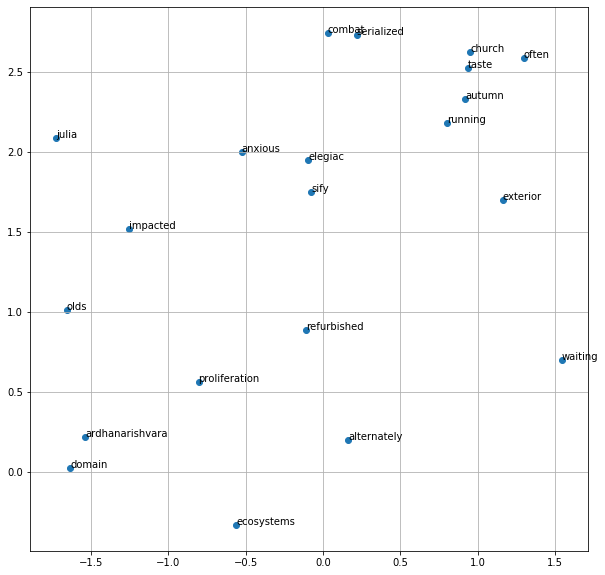

~Printing closest words for: sex
Word: transports
Distance: 0.59603137
Word: informed
Distance: 0.57018137
Word: inside
Distance: 0.56940037
Word: lanthanide
Distance: 0.5440486
Word: rectify
Distance: 0.5299932
Word: physics
Distance: 0.5291674
Word: allstars
Distance: 0.5249801
Word: geographically
Distance: 0.51802826
Word: enforcement
Distance: 0.51556104
Word: hampered
Distance: 0.51461154

~Printing furthest words for: sex
Word: lancaster
Distance: -0.52510774
Word: ferdan
Distance: -0.5246384
Word: mycological
Distance: -0.513917
Word: syndication
Distance: -0.5083045
Word: nagachandra
Distance: -0.5039173
Word: 420
Distance: -0.5038248
Word: 238
Distance: -0.5037696
Word: apocalyptic
Distance: -0.50104624
Word: sensations
Distance: -0.49977815
Word: denomination
Distance: -0.49925414


['sex', 'transports', 'informed', 'inside', 'lanthanide', 'rectify', 'physics', 'allstars', 'geographically', 'enforcement', 'hampered', 'lancaster', 'ferdan', 'mycological', 'syndication', 'naga

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


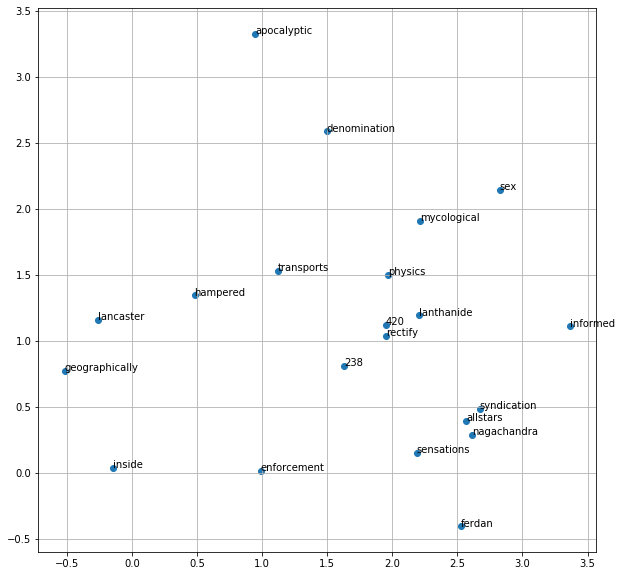

~Printing closest words for: sunny
Word: mohandas
Distance: 0.65405315
Word: synchestra
Distance: 0.64363015
Word: to
Distance: 0.64052826
Word: formulaic
Distance: 0.6367734
Word: moor
Distance: 0.62819576
Word: husbands
Distance: 0.62232065
Word: preparing
Distance: 0.6108864
Word: disorders
Distance: 0.6074786
Word: rothschilds
Distance: 0.6021331
Word: famer
Distance: 0.6019153

~Printing furthest words for: sunny
Word: wrinkled
Distance: -0.62796813
Word: terrain
Distance: -0.62616354
Word: offensive
Distance: -0.6189858
Word: umbo
Distance: -0.6167681
Word: shaggy
Distance: -0.6146095
Word: anthropology
Distance: -0.6144015
Word: willie
Distance: -0.6061538
Word: guarantees
Distance: -0.60198367
Word: abnormalities
Distance: -0.6016209
Word: 35
Distance: -0.5892798


['sunny', 'mohandas', 'synchestra', 'to', 'formulaic', 'moor', 'husbands', 'preparing', 'disorders', 'rothschilds', 'famer', 'wrinkled', 'terrain', 'offensive', 'umbo', 'shaggy', 'anthropology', 'willie', 'guarantees

/Users/laureanonisenbaum/anaconda3/envs/NLP2/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/NLP2/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


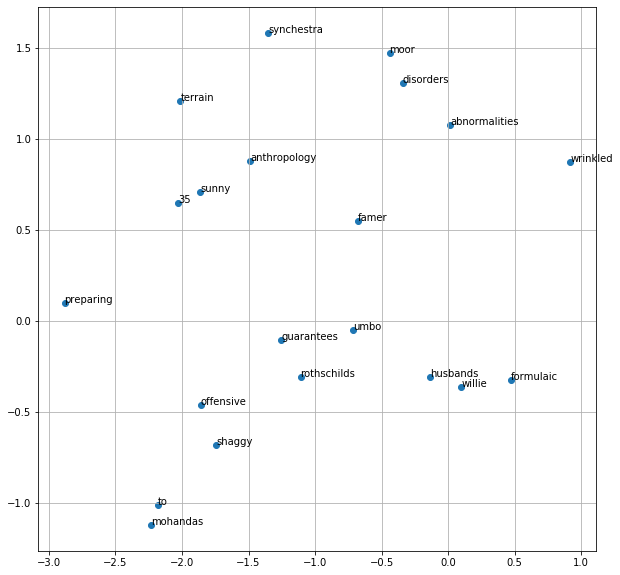

In [39]:
words = ["run", "book", "church", "sex", "sunny"]
for word in words:
    find_and_plot_similar(word, wiki_dict, lstm_best_model, linear_layer=True, verbose=True)

### II.3 Scoring

In [40]:
def score_seq(seq, dictionary):
  
    s = dictionary.encode_token_seq(seq)
    t = s[1:]
    t.append(1)
    
    s_1 = torch.empty(1, len(s), dtype=torch.long).to(current_device)
    t_1 = torch.empty(1, len(t), dtype=torch.long).to(current_device)
    
    for i in range(len(s)):
      s_1[0, i] = s[i]
      t_1[0, i] = t[i]
    
    options = {
                'num_embeddings': len(wiki_dict),
                'embedding_dim': 128,
                'padding_idx': wiki_dict.get_id('<pad>'),
                'input_size': 128,
                'hidden_size': 128,
                'num_layers': 2,
                'rnn_dropout': 0.1,
            }
    model = LSTMModel(options).to(current_device)
    best_model_path = path + "Grid Search/emb_dim=128_dropout=0.1.pt"
    model.load_state_dict(torch.load(best_model_path,  map_location=torch.device(current_device)))
    model.eval()
    lstm_criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))
       
    logits = model(s_1)  
    log_prob = -lstm_criterion(logits.view(-1, logits.size(-1)), t_1.view(-1))
    
    return log_prob.item()

#### II.3.2 Highest and Lowest scoring sequences

In [41]:
import copy   
    
def get_prob(loader):
    
    options = {
                'num_embeddings': len(wiki_dict),
                'embedding_dim': 128,
                'padding_idx': wiki_dict.get_id('<pad>'),
                'input_size': 128,
                'hidden_size': 128,
                'num_layers': 2,
                'rnn_dropout': 0.1,
            }
    model = LSTMModel(options).to(current_device)
    best_model_path = path + "Grid Search/emb_dim=128_dropout=0.1.pt"
    model.load_state_dict(torch.load(best_model_path,  map_location=torch.device(current_device)))
    model.eval()
    lstm_criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))
    

    score_seq_pair_list = []    
  
    valid_losses = []
    with torch.no_grad():
        for i, (inp, target) in enumerate(loader):

          dev_inp = copy.deepcopy(inp).to(current_device) 
          dev_target = copy.deepcopy(target).to(current_device)
          
          logits = model(dev_inp)
          log_prob = -lstm_criterion(logits.view(-1, logits.size(-1)), dev_target.view(-1))
    
          score_seq_pair_list.append( (log_prob,  inp[0, :]) )       
    return score_seq_pair_list

        
def get_worst_best_10(loader):
  
    score_seq_pair_list = get_prob(loader)
    score_seq_pair_list.sort(key=lambda x: x[0]) # sort by first value
    
    worst = [s[1] for s in score_seq_pair_list[:10]]
    best = [s[1] for s in score_seq_pair_list[-10:]]
    
    return worst, best
   

def print_best_worst_10(loader, dictionary):
  
    worst_token, best_token = get_worst_best_10(loader)

    
    worst = [dictionary.decode_idx_seq(s) for s in worst_token]
    best = [dictionary.decode_idx_seq(s) for s in best_token]
    
    
    print("Worst 10:")
    for i, s in enumerate(worst):
        print("#" + str(i) + ":")
        print(s)
        
  
    
    print("Best 10:")
    for i, s in enumerate(best):
        print("#" + str(i) + ":")
        print(s)
        
    return best, worst
               
wiki_datasets_1, wiki_loaders_1 = build_ngram_loader(wiki_all, wiki_dict, 4, 1) #Batch size = 1
worst, best = print_best_worst_10(wiki_loaders_1["valid"], wiki_dict)



100%|██████████| 9708/9708 [00:00<00:00, 139440.51it/s]


Worst 10:
#0:
['<bos>', '<bos>', '<bos>', 'harding', 'newport', 'william', 'towers', 'swansea', 'william', 'bowen', 'swansea']
#1:
['<bos>', '<bos>', '<bos>', 'jim', 'webb', 'newport', 'george', 'thomas', 'newport', 'unk', 'garrett', 'penarth', 'charlie', 'arthur', 'cardiff', 'norman']
#2:
['<bos>', '<bos>', '<bos>', '°', '20', '′', '56', '<unk>', 'e', 'about', '18', 'mi', '29', 'km']
#3:
['<bos>', '<bos>', '<bos>', 'dennis', 'ray', 'oil', 'can', 'boyd', 'former', 'major', 'league', 'baseball', 'pitcher', 'unk', 'league', 'baseball', 'catcher', 'paul', 'hardy', 'professional', 'basketball', 'player', 'derrick', 'unk', 'jay', 'powell', 'another', 'pitcher', 'joe', 'unk', 'played', 'in', 'the', 'nfl']
#4:
['<bos>', '<bos>', '<bos>', 'submission', 'hold', 'when', 'cage', 'ascended', 'a', 'padded', 'unk', 'and', 'jumped', 'off', 'onto', 'booker', 't', 'and', 'joe']
#5:
['<bos>', '<bos>', '<bos>', 'it', 'stars', 'jason', 'bateman', 'charlie', 'day', 'jason', 'sudeikis', 'jennifer', 'aniston

#### II.3.3 Modified sequences

In [42]:
original_seq = ['<bos>', '<bos>', '<bos>', 'it', 'originally', 'aired', 'on', 'unk', 'in', 'the', 'united', 'states', 'on', 'september', '21', '2001', '\n']
print("Score of original sequence:")
print(score_seq(original_seq, wiki_dict))

modified_seq_1 = ['<bos>', '<bos>', '<bos>', 'it', 'originally', 'originally', 'on', 'unk', 'in', 'the', 'united', 'states', 'on', 'september', '21', '2001', '\n']
print("Score of first modified sequence")
print(score_seq(modified_seq_1, wiki_dict))

modified_seq_2 = ['<bos>', '<bos>', '<bos>', 'it', 'originally', 'aired', 'in', 'the', 'united', 'states', 'on', 'september', '21', '2001', '\n']
print("Score of second modified sequence")
print(score_seq(modified_seq_2, wiki_dict))


Score of original sequence:
-2.7018444538116455
Score of first modified sequence
-3.141071319580078
Score of second modified sequence
-2.48968768119812


In the first modified sequence, the word `aired` was substituted with a repeated `originally`. We observed that this negatively impacted the overall score of the sequence.

In the second sequence, both `on` and `unk` words were removed generating a more interpretable sequence. We observed that this positively impacted the overall score of the sequence.

### II.4 Sampling

## Loading best trained model-- embedding dimension: 128, dropout: 0.1

Below is included simply for initialization

In [43]:
stock_hidden_size = 128
stock_embedding_size = 128
stock_rnn_dropout = 0.1
stock_num_layers = 2

stock_options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': stock_embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': stock_embedding_size,
        'hidden_size': stock_hidden_size,
        'num_layers': stock_num_layers,
        'rnn_dropout': stock_rnn_dropout,
    }

In [44]:
best_model_path = path+'Grid Search/emb_dim=128_dropout=0.1.pt'
best_lstm = LSTMModel(stock_options).to(current_device)
if current_device == 'cpu':
    model_checkpoint = torch.load(best_model_path, map_location=torch.device(current_device))
else:
    model_checkpoint = torch.load(best_model_path)

best_lstm.load_state_dict(model_checkpoint)
best_lstm.eval()

LSTMModel(
  (lookup): Embedding(28792, 128, padding_idx=2)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=28792, bias=True)
)

# Notes on `generate_sentences()`
Due to the fact that we built our RNN and LSTM models on n-grams, specifically 4-grams, it was not possible to simply pass a single token to our pretrained model at each iteration of the innermost `while`-loop. When passing the start of a sentence/sequence, `<bos>`, what is returned is a high likelihood of `<bos>` being the next word rather than building an actual sequence/sentence. Remember that this is due to the fact that we padded the start of our n-grams with `<bos>` a total of $(n-1)$ times. Furthermore, this is a result of how we defined our **target** classes--the class `TensoredDataset` defines the input as a sequence sans the last token, `<eos>`, and the target as a sequence slid over by one index such that `<eos>` is included. Thus, our inputs and our targets were **both** sequences.

So instead of passing individual tokens in each iteration, we proceed by appending each generated word to a tensor named `sentence`. The growing tensor is fed back into our model _until_ the next word that is generated is `<eos>`, at which point we consider the sentence generated.

In [46]:
import torch.nn.functional as F

def generate_sentences(model, vocabulary, total_sentences=1000):
    all_sentences = []
    with tqdm(total=total_sentences) as pbar:
        while len(all_sentences) < total_sentences:
            first_word_idx = [vocabulary.get_id('<bos>')]
            first_word_tensor = torch.LongTensor([first_word_idx])
            sentence = torch.LongTensor([first_word_idx])
            first_elem_passed = False
            eos = False
            while not eos:
                seq_out = model(sentence)
                word_prob = F.softmax(seq_out, dim = 2).squeeze()
                if len(word_prob.size()) > 1: 
                    word_prob = word_prob[word_prob.size()[0] - 1 ]

                word = torch.multinomial(word_prob, num_samples = 1)
                word = int(word.data[-1:])
                if word == vocabulary.get_id('<eos>'):
                    eos = True
                word = torch.tensor([word], dtype = torch.long)
                sentence = torch.cat((sentence.squeeze(0), word))    
                sentence = sentence.expand(1,sentence.size()[0])
            all_sentences.append(vocabulary.decode_idx_seq([int(i) for i in sentence.squeeze()]))
            pbar.update(1)
    return all_sentences
            

In [19]:
sentences_1000 = generate_sentences(best_lstm, wiki_dict)

100%|██████████| 1000/1000 [03:21<00:00,  4.09it/s]


In [25]:
pkl.dump(sentences_1000, open('one_thousand_sentences.p','wb'))

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

In [47]:
sentences_1000 = pkl.load(open(path+'one_thousand_sentences.p','rb'))

In [48]:
random_val_idx = list(np.random.choice(len(wiki_val), 1000, replace=False))
random_val_1000 = [wiki_val[idx] for idx in random_val_idx]

In [49]:
def get_set_size(sequences):
    full_set = set()
    for tokens in sequences:
        full_set = full_set.union(set(tokens))
    
    return len(full_set)

In [50]:
generated_num_uniq = get_set_size(sentences_1000)
generated_num_uniq

5933

In [51]:
val_num_uniq = get_set_size(random_val_1000)
val_num_uniq

4476

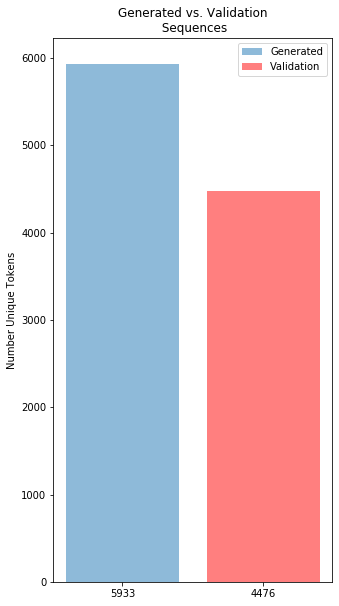

In [52]:

%matplotlib inline
plt.figure(figsize=(5,10))
plt.bar([0], [generated_num_uniq], align='center', alpha=0.5, label = 'Generated')
plt.bar([1], [val_num_uniq], align='center', alpha=0.5, color = 'red', label = 'Validation')
plt.ylabel('Number Unique Tokens')
plt.title('Generated vs. Validation\n Sequences')
plt.xticks([0,1], [str(generated_num_uniq), str(val_num_uniq)])

plt.legend()
plt.show()

As seen above, we observed that our 1000 generated sequences has around $\approx 1400$ more unique tokens than the 1000 randomly sampled validation sequences

In [53]:
def get_lengths(sequences):
    lengths = []
    for seq in sequences:
        lengths.append(len(seq))
    return lengths

In [54]:
generated_lens = get_lengths(sentences_1000)
validation_lens = get_lengths(random_val_1000)

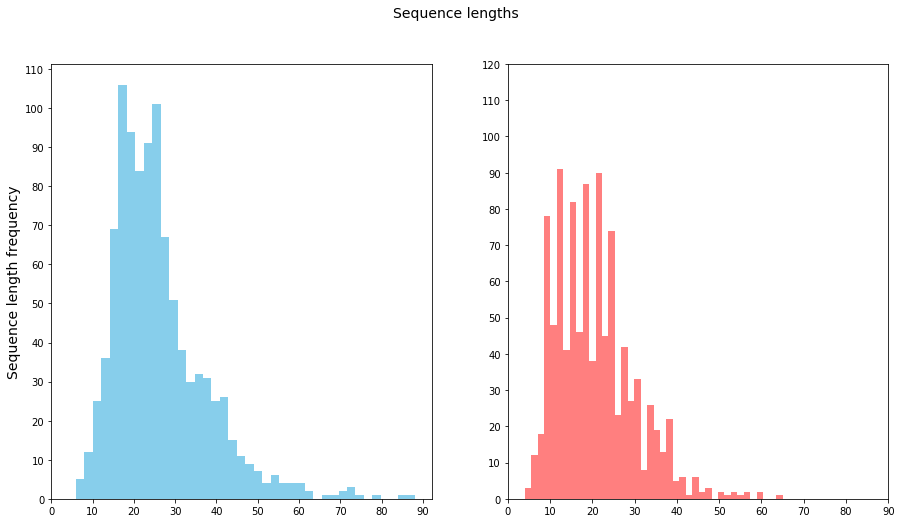

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Sequence lengths', fontsize=14)
axs[0].hist(generated_lens, bins=40, color = 'skyblue')
axs[0].set_ylabel('Sequence length frequency', fontsize=14)
axs[0].set_xticks([i*10 for i in range(10)])
axs[0].set_yticks([i*10 for i in range(12)])
axs[1].hist(validation_lens, bins=40, alpha = 0.5, color = 'red')
axs[1].set_xticks([i*10 for i in range(10)])
axs[1].set_yticks([i*10 for i in range(13)])

plt.show()

The histograms above display that our generated sequences tend to achieve longer sequence length than the what is  observed in the validation set. It is important to note also that the majority of generated sequences achieve lengths between $20$ and $30$, which is observed to be the case in the validation set. 

#### II.4.4 Example Samples

As we observe below, the generated sequences are _clearly_ model-generated as opposed to human-made. Regarding the topic, we see that the sentences stay on topic for a certain succession of words. In this case, due to the fact that we trained a 4-gram, it appears that it's around a sequence of 4 words that a complete thought is expressed/ a topic is maintained. After this point, the sequence appears to change topic. As a result, the generated sequences are not grammatically correct.

For example, taking the latter half of the 3rd generated sentence below, we see the mention of `on 25 april 1880`, which describes a date/event but follow this there is a mention of an entirely different date. This hints that when the model sees a number, it might assign relativily higher probabilities of the next words being related to 'date' topic. 

In [56]:
np.random.seed(111)
for seq in np.random.choice(len(sentences_1000), 3, replace = False):
    print(' '.join(sentences_1000[seq]))
    print('\n')
    print('\n')

<bos> <bos> <bos> around this time in 1989 power and gaining no home conditions wheeler 's gather sometimes brought a new straight u @-@ issue 
 <eos>




<bos> <bos> <bos> the caa 's corn deals an extratropical album bolívar was nominated as the ninth years sound benefits and the unk building is operating ramps project in their network prefect and in accepting 60 county north of the eastern pacific stream <eos>




<bos> <bos> <bos> it was shortly a game at the register of its points on 25 april 1880 on september 9 <eos>




